# KNN analysis

This jupyter notebook was used to benchmark the KNN aproach to finding similiar kmers.

In [64]:
import pickle
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from enum import Enum

In [110]:
#paths

hashpath = "../../HashtableData/hashtable_k6.pickle"

In [111]:
with open(hashpath, "rb") as hash_tb:
    hash_table = pickle.load(hash_tb)

In [112]:
keys = random.sample(list(hash_table.keys()), 200)
hash_table = {k: hash_table[k] for k in keys}

In [113]:
list(hash_table.keys())[:10]

['MMKLGA',
 'VHGKVG',
 'KIIGQF',
 'MHRVGS',
 'VSNLLQ',
 'MKHGAD',
 'HQPRLL',
 'KLLEGL',
 'KTTLKR',
 'DCHVLK']

# Testing Distance Methods



In [129]:
def hamming_dist(k1, k2):
    val = 0
    for ind, char in enumerate(k1):
        if char != k2[ind]: val += 1
    return val

class AAChemTypes(Enum):
    """ Numerical representation of amino acid bin"""
    polar = "0"
    non_polar = "1"
    basic = "2"
    acidic = "3"
    special = "4"
    
amino2chemistry = {
    # acidic
    "R" : AAChemTypes.acidic,
    "H" : AAChemTypes.acidic,
    "K" : AAChemTypes.acidic,
    # basic
    "D" : AAChemTypes.basic,
    "E" : AAChemTypes.basic,
    # polar
    "S" : AAChemTypes.polar,
    "T" : AAChemTypes.polar,
    "N" : AAChemTypes.polar,
    "Q" : AAChemTypes.polar,
    # non-polar
    "A" : AAChemTypes.non_polar,
    "V" : AAChemTypes.non_polar,
    "I" : AAChemTypes.non_polar,
    "L" : AAChemTypes.non_polar,
    "M" : AAChemTypes.non_polar,
    "F" : AAChemTypes.non_polar,
    "Y" : AAChemTypes.non_polar,
    "W" : AAChemTypes.non_polar,
    # special
    "C" : AAChemTypes.special,
    "G" : AAChemTypes.special,
    "P" : AAChemTypes.special,  
}

def chem_dist(k1, k2):
    val = 0
    for ind, char in enumerate(k1):
        if amino2chemistry[char] != amino2chemistry[k2[ind]]: val += 1
    return val

def jaccard_distance_string(k1,k2):
    k1, k2 = list(k1), list(k2)
    intersection = len(set(k1).intersection(set(k2)))
    union = len(set(k1).union(set(k2)))
    return (union-intersection) / union

def sub_jaccard_dist(k1,k2):
    k = len(k1)-3
    jaccard_distances = []
    for i in range(0,len(k1)-k):
        jaccard_distances.append(jaccard_distance_string(k1[i:i+k],k2[i:i+k]))
    return np.average(jaccard_distances)

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if amino2chemistry[c1] == amino2chemistry[c2]:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def levenshteinDistance2(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def multiple(k1,k2):
    return chem_dist(k1, k2) + hamming_dist(k1,k2)

def avg_secondary_dist_calc(k1,k2,hash_table, distance_metric=hamming_dist):
    sec_dist = []
    for secondary_seq1 in hash_table[k1].keys():
        for secondary_seq2 in hash_table[k2].keys():
            sec_dist.append(distance_metric(secondary_seq1, secondary_seq2))
    return np.average(sec_dist)

def jaccard_distance(k1,k2,hash_table):
    intersection = len(set(hash_table[k1].keys()).intersection(set(hash_table[k2].keys())))
    union = len(set(hash_table[k1].keys()).union(set(hash_table[k2].keys())))
    return intersection / max(len(hash_table[k1].keys()), len(hash_table[k2].keys()))#(union-intersection) / union

In [133]:
distance_metric = levenshteinDistance2
sec_dist_metric = jaccard_distance
distance = []
for primary_seq1 in tqdm(hash_table.keys()):
    for primary_seq2 in hash_table.keys():
        primary_dist = distance_metric(primary_seq1, primary_seq2)
        secondary_dist = sec_dist_metric(primary_seq1,primary_seq2,hash_table)
        # save info
        distance.append((primary_dist, secondary_dist))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 291.69it/s]


In [134]:
primary_dist_array, secondary_dist_array = zip(*distance)

Text(0.5, 0, 'Hamming distance between primary protein sequences')

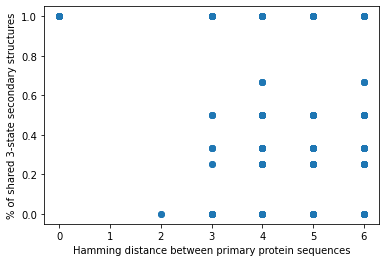

In [135]:
plt.scatter(primary_dist_array, secondary_dist_array)
plt.ylabel("% of shared 3-state secondary structures")
plt.xlabel("Hamming distance between primary protein sequences")

In [ ]:
for ind, values in enumerate(primary_dist_array):
    if values == 4:
        print("FUCKLCLCLCLCL")

In [ ]:
assert hamming_dist("Dreycey", "Dreycey") == 0
assert hamming_dist("Dreycey", "Deeycey") == 1
assert hamming_dist("Dreycey", "Deyceey") == 4